# Character RNN
#### Description:
We implement a character-level recurrent neural network using the GRU as our recurrent unit. We train on the CharRNN on Michael Jackson lyrics, and get some interesting results.

In [3]:
# !pip3 install torch
# !pip3 install torchvision
# !pip3 install tqdm
!pip3 install unidecode

     |################################| 245kB 560kB/s eta 0:00:01


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision
import torch.optim as optim
from torch.autograd import Variable

import os
import zipfile
import matplotlib.pyplot as plt

import unidecode
import string
import random
import time
 
import pdb

# Dataset Class

In [15]:
class TextDataset(Dataset):
    def __init__(self, chunk_len=200, upload_files=False, file_name="michael-jackson.txt"):
        """Creates a Pytorch Dataset from a text corpus.
        Args:
            chunk_len (int): the length of each training segment of text
            upload_file (bool): whether or not to upload your own text corpus to train on
            file_name (str): the name of the file to train on. A full list of files is found here: https://www.kaggle.com/paultimothymooney/poetry
        """
        
        root = '../data/'

        if upload_files:
            uploaded = files.upload() # Upload your own file
            file_name = list(uploaded.keys())[0]
            os.rename(file_name, os.path.join(root, file_name))
            
        text_files = os.listdir(root)
        self.training_file = text_files[text_files.index(file_name)]
        self.training_file = unidecode.unidecode(open(os.path.join(root, self.training_file)).read())
        self.segment_extractor = self.FileSegmentExtractor(self.training_file, chunk_len)

        with open(self.training_file, 'r') as file:
            text = file.read().strip().split()
            self.len = sum(len(word) for word in text)

    @staticmethod
    def extract_zip(zip_path):
        """Extraxts a file in .zip format to the root directory
        Args:
            zip_path (str): the path to the zip file
        """
        print('Unzipping {}'.format(zip_path))
        with zipfile.ZipFile(zip_path,"r") as zip_ref:
            zip_ref.extractall(os.path.dirname(self.root))
    
    def __len__(self):
        return self.len
        
    class FileSegmentExtractor():
        def __init__(self, training_file, chunk_len):
            """Extracts chunk_len segments from the data for training
            Args:
                training_file (str): the training file path
                chunk_len (int): the number of characters in each chunk
            """
            self.chunk_len = chunk_len
            self.training_file = training_file
            self.file_len = len(self.training_file)
            # A string including all printable characters
            self.all_characters = string.printable
            self.n_characters = len(self.all_characters)
            
        def random_chunk(self):
            """Extracts a random chunk from the file
            Returns:
                (str): a string of length (chunk_len)
            """
            start_index = random.randint(0, self.file_len - self.chunk_len)
            end_index = start_index + self.chunk_len + 1
            return self.training_file[start_index:end_index]

        def char_tensor(self, string):
            """Converts characters in a string to a numerical index representing that character.
            Args:
                string (str): the string to convert
            Returns:
                tensor (torch.Tensor): a tensor containing the indices of each letter in the string
            """
            tensor = torch.zeros(len(string)).long()
            for c in range(len(string)):                
                tensor[c] = self.all_characters.index(string[c])
            return tensor

        
        def random_training_set(self):
            """Obtains a random set of data to train on.
            Returns:
                inp (torch.Tensor): a chunk of characters from the file
                target (torch.Tensor): the same chunk of characters offset by one
            """
            chunk = self.random_chunk()
            inp = self.char_tensor(chunk[:-1])
            target = self.char_tensor(chunk[1:])
            return inp, target

# Take a look at the data

In [16]:
# def explore_data():
#     all_characters = string.printable
#     n_characters = len(all_characters)

#     file = unidecode.unidecode(open('./text_files/text_files/lotr.txt').read())
#     file_len = len(file)
#     print('file_len =', file_len)

#     chunk_len = 200

#     def random_chunk():
#         start_index = random.randint(0, file_len - chunk_len)
#         end_index = start_index + chunk_len + 1
#         return file[start_index:end_index]

#     print(random_chunk())
    
# explore_data()

dataset = TextDataset()

UnicodeDecodeError: 'ascii' codec can't decode byte 0xc2 in position 184148: ordinal not in range(128)

# GRU Implementation

In [0]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.wr = nn.Linear(input_size + hidden_size, hidden_size)
        self.wz = nn.Linear(input_size + hidden_size, hidden_size)
        self.w = nn.Linear(input_size + hidden_size, hidden_size)
        
    def forward(self, x_input, prev_hidden):
        zt = self.sig(self.wz(torch.cat((x_input, prev_hidden), dim=2)))
        rt = self.sig(self.wr(torch.cat((x_input, prev_hidden), dim=2)))
        h_tilde = self.tanh(self.w(torch.cat((torch.mul(rt, prev_hidden), x_input), dim=2)))
        ht = torch.mul((1 - zt), prev_hidden) + torch.mul(zt, h_tilde)
        return ht, ht

# RNN

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()

        # Input: An integer encoding of the character
        self.input_size = input_size
        # Output: A categorical distribution over characters
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        # An embedding layer is different from a linear layer because it provides
        # lookup capability -- each character has its own trained embedding. A
        # linear layer is different, as all input characters share the same weights
        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        self.relu = nn.ReLU()
        # The first argument is self.hidden_size because we've embedded the input to be the same size as the hidden_state
        self.gru = GRU(self.hidden_size, self.hidden_size)
        self.to_output_size = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1) #dim=1

    def forward(self, input_char, hidden_state):
        embed = self.embedding(input_char).view(1,1,-1)
        output, hidden = self.gru(embed, hidden_state)
        output = self.relu(self.to_output_size(output))
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

# Training Loop

In [0]:
def train(input_string, target_string, decoder, decoder_optimizer, criterion):
    # initialize hidden layers, set up gradient and loss
    loss = 0
    hidden = decoder.init_hidden()
    num_classes = len(string.printable)
    i = 0
    decoder_optimizer.zero_grad()
    
    for in_char, target_char in zip(input_string, target_string):
        
        
        char_hat, hidden = decoder(in_char, hidden)
        target_char = target_char.unsqueeze(0)
        loss += criterion(char_hat.squeeze(0), target_char)
    
        i += 1
        
    loss.backward()
    decoder_optimizer.step()
        
    return loss.item() / len(input_string)
        
    
def scope():
    all_characters = string.printable
    n_epochs = 5000
    print_every = 500
    plot_every = 10
    in_size = len(all_characters)
    hidden_size = 100
    output_size = len(all_characters)
    lr = 0.005
    n_layers = 1
    file_name = "mj.txt"
    
    def char_tensor(string):
        tensor = torch.zeros(len(string)).long()
        for c in range(len(string)):                
            tensor[c] = all_characters.index(string[c])
        return tensor
    
    def evaluate(prime_str='A', predict_len=100, temperature=0.8):
        
        hidden = decoder.init_hidden()
        predicted = prime_str
        prime_input = char_tensor(prime_str)

        # Use priming string to "build up" hidden state
        for p in range(len(prime_str) - 1):
            _, hidden = decoder(prime_input[p], hidden)
        inp = prime_input[-1]

        for p in range(predict_len):
            
            output, hidden = decoder(inp, hidden)
            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]
            
            char_choice = all_characters[top_i]
            inp = char_tensor(char_choice)
            predicted += char_choice

        return predicted
    
    train_dataset = TextDataset(file_name=file_name, upload_files=True)
    
    decoder = RNN(in_size, hidden_size, output_size, n_layers=n_layers)
    
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    all_losses = []
    running_loss = 0
    start = time.time()
    for epoch in range(n_epochs + 1):
        
        input_string, target_string = train_dataset.segment_extractor.random_training_set()
        loss_ = train(input_string, target_string, decoder, decoder_optimizer, criterion)
        running_loss += loss_
        
        if epoch % print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
            print(evaluate('Wh', 100), '\n')
            
        if epoch % plot_every == 0:
            all_losses.append(running_loss / (epoch + 1))
            
    plt.plot(range(len(all_losses)), all_losses, label='Loss')
    plt.xlabel("Epoch / {}".format(plot_every))
    plt.ylabel("Loss")

# Results - Michael Jackson is back!

Saving mj.txt to mj.txt
[0.21973276138305664 (0 0%) 4.6048]
Wh!f/ok{7G\G?icq.3w1B\c775:j?	\"q2MM_O$UQ~^!Ykp-2ZPWtVjIRKa`ZM<H !='"j)h8gfH3KKy89|RoDfX;<67nn6	u8' 

[110.88017725944519 (500 10%) 1.8180]
Wht swe


Ooow we're it she dreatake Ne love my haod I and thoug heart fechell you

Is Chin' al can 
I 

[220.07144808769226 (1000 20%) 2.0049]
Whenny beat me it's rid/ressay
We're be say it me firlone
Leave mangeude agsacky bosthout it
Don't let 

[329.8291029930115 (1500 30%) 1.6105]
Who....

3ru
A not a hear is me in gonna the long
Oh when be all away
You know now
I'm beyout a brone  

[441.4710786342621 (2000 40%) 1.9380]
When I gow
Share the wantbess hay she butter sky
The show is have on baby
You the by the have the morn 

[551.5370712280273 (2500 50%) 1.5780]
When What Of Me
You &chiving Me (Your Reallyou Make A My Have Michance Off]
Gon On Te Her Me
(Whone Wo 

[661.6849853992462 (3000 60%) 0.8295]
What back in dance
You tree the dange mine

Would no precually get about on they 

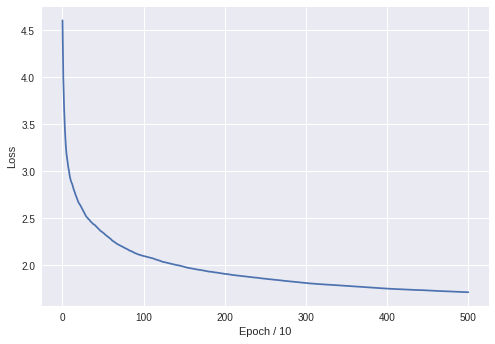

In [130]:
scope()

In [0]:
# To do: 
# Include option for reading lines at a time
# Include option for multiple layers